In [47]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from scipy.linalg import eig
import time

ImportError: cannot import name 'Timer' from 'timer' (/home/roman/miniconda3/envs/python39/lib/python3.9/site-packages/timer/__init__.py)

In [144]:
class Network():
    def __init__(self, p_selflink=1, n_agents=1000):
        self.truth = random.uniform(0,1)
        self.p_selflink = p_selflink
        self.weights, self.beliefs = self.grow_network_instant(n_agents=n_agents)
        self.speed_test(n_agents=n_agents, increase_degree=False)
    
    def gen_t0(self):
        # First agent always has a self link to ensure aperiodicity
        adjacency = np.ones((1,1))
        return adjacency
    
    def speed_test(self, n_agents, increase_degree=False):
        instant = []
        incremental = []
        for k in range(10):
            instant_time = []
            incremental_time = []
            sizes = []
            for i in tqdm(range(0, n_agents+1, 100)):
                sizes.append(i)

                t_start = time.perf_counter()
                network_instant, _ = self.grow_network_instant(n_agents=i, increase_degree=increase_degree)
                t_end = time.perf_counter()
                instant_time.append((t_end-t_start)*1000)
                if k==9 and i>0:
                    instant_out_degree = np.count_nonzero(network, axis=1)
                    instant_in_degree = np.count_nonzero(network, axis=0)

                t_start = time.perf_counter()
                network = self.gen_t0()
                for j in range(i):
                    network = self.grow_network_concat(network)
                if increase_degree:
                    for n in range(network.shape[0]):
                        add_in_degree = int(np.floor(np.random.normal(2, 1)))
                        add_out_degree = int(np.floor(np.random.normal(2,1)))

                        if add_in_degree > 0:
                            for _ in range(add_in_degree):
                                j = np.random.randint(0, network.shape[0])
                                network[j, n] = 1

                        if add_in_degree > 0:
                            for _ in range(add_out_degree):
                                j = np.random.randint(0, network.shape[0])
                                network[n, j] = 1
                t_end = time.perf_counter()
                incremental_time.append((t_end-t_start)*1000)
                if k==9 and i>0:
                    incremental_out_degree = np.count_nonzero(network, axis=1)
                    incremental_in_degree = np.count_nonzero(network, axis=0)
                
                
            instant.append(instant_time)
            incremental.append(incremental_time)            
            
        plt.plot(sizes, np.mean(np.array(instant), axis=0), label="Instant")
        plt.plot(sizes, np.mean(np.array(incremental), axis=0), label="Incremental")
        plt.legend()
        plt.show()
        
        plt.hist(instant_out_degree, bins=np.amax(instant_out_degree))
        plt.show()
        plt.hist(instant_in_degree, bins=np.amax(instant_in_degree))
        plt.show()
        
        plt.hist(incremental_out_degree, bins=np.amax(incremental_out_degree))
        plt.show()
        plt.hist(incremental_in_degree, bins=np.amax(incremental_in_degree))
        plt.show()
        
        
    def test_to_wisdom(self, n_agents):
        # Create network
        self.weights, self.beliefs = self.grow_network_instant(n_agents)
        convergence_times = []
        
        # Get time to converge for each n
        for i in range(n_agents):
            # Get stochastic matrix from weights matrix
            T = normalize_weights(self.weights[:i+1, :i+1])
            # Converge network and save the time
            t_to_convergence = self.converge_network(T)
            convergence_times.append(t_to_convergence)
            
            # Check if network is wise
            if (T@np.array(self.beliefs)[:i+1])[0] == self.truth:
                # Number of agents at which the network became wise
                return i+1, convergence_times
        else:
            # If the initial size of the network was not sufficient
            # to attain wisdom grow it incrementally until it does
            while (T@np.array(self.beliefs))[0] != self.truth:
                # Grow network, beliefs, and normalize the weights
                self.weights = self.grow_network_concat(self.weights)
                T = self.normalize_weights(self.weights)
                self.beliefs = self.grow_beliefs(self.beliefs)
                
                # Converge the network
                t_to_convergence = self.converge_network(T)
                convergence_times.append(t_to_convergence)
                
        return self.beliefs.shape[0]+1, converge_times
    
    def normalize_weights(self, weights):
        return weights/weights.sum(1)[:, np.newaxis]
    
    def grow_network_concat(self, weights):
        """
        Grows the existing network by 1 agent.
        Creates links between this agent and the existing agents in the network.
        
        """
        
        # Grow network by one agent by concatenating a row and column of zeroes
        weights = np.concatenate((weights, np.zeros((1, weights.shape[1]))), axis=0)
        weights = np.concatenate((weights, np.zeros((weights.shape[0], 1))), axis=1)
        
        # Determine randomly if a self-link should be generated
        if random.uniform(0,1) <= self.p_selflink:
            weights[weights.shape[0]-1, weights.shape[1]-1] = 1
        
        # Create connections with the new agents in the network
        # Always at least one incoming and outgoing link, to preserve strong connectedness
        out_agent = np.random.randint(weights.shape[0]-1)
        in_agent = np.random.randint(weights.shape[0]-1)
        
        weights[weights.shape[0]-1, out_agent] = 1
        weights[in_agent, weights.shape[1]-1] = 1
        
        return weights
            
    def grow_network_instant(self, n_agents, increase_degree=False):
        """
        Creates a network of size n_agents x n_agents and makes the links.
        
        Input:
            n_agents: int, number of agents (and therefore dimensions) of the network
        Output:
            network: array, size n_agents x n_agents representing the network
        """
        
        weights = np.zeros((n_agents, n_agents))
        beliefs = []
        
        #for i in tqdm(range(n_agents)):
        for i in range(n_agents):
            # Ensure first agent receives a self loop to ensure aperiodicity
            if i == 0:
                weights[0,0] = 1
                continue
            
            # Determine which agents will recieve and send a link to agent i
            # Must have on of both to ensure full connectedness.
            # Chosen from the range of 
            in_link = np.random.randint(i)
            out_link = np.random.randint(i)
            
            if not weights[in_link, i]:
                weights[in_link, i] = 1
            weights[i, out_link] = 1
            
            if random.uniform(0,1) <= self.p_selflink:
                weights[i,i] = 1
            
            if increase_degree:            
                add_in_degree = int(np.floor(np.random.normal(2, 1)))
                add_out_degree = int(np.floor(np.random.normal(2, 1)))

                if add_in_degree > 0:
                    for _ in range(add_in_degree):
                        j = np.random.randint(0, n_agents)
                        weights[j, i] = 1
                if add_out_degree > 0: 
                    for _ in range(add_out_degree):
                        j = np.random.randint(0, n_agents)
                        weights[i, j] = 1
            
            beliefs = self.grow_beliefs(beliefs)
                
        return weights, beliefs
    
    def grow_beliefs(self, beliefs):
        signal = self.gen_signal()
        if signal < 0:
            beliefs.append(0)
        elif signal > 1:
            beliefs.append(1)
        else:
            beliefs.append(signal)
        return beliefs
    
    def gen_signal(self):
        return np.random.normal(self.truth, self.truth**2)
    
    def converge_network(self, T):
        """
        Converges the current network.
        Returns the amount of iterations required for convergence
        
        Output:
            counter: int, the step t at which the network converges
        """
        counter = 0
        prev_T = np.zeros(T.shape)
        while (prev_T - T).sum() != 0:
            prev_T = T
            T = T @ self.T
            counter+=1
        return counter-1

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

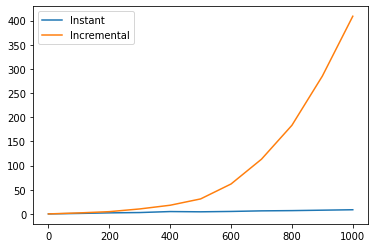

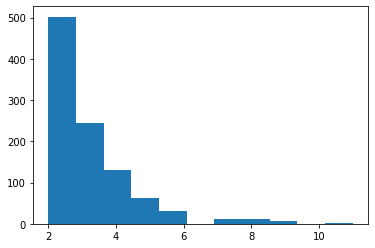

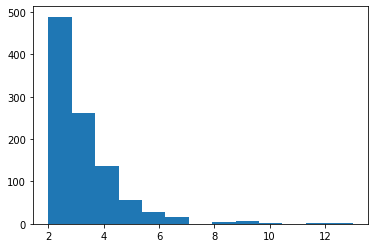

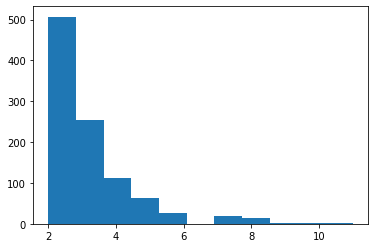

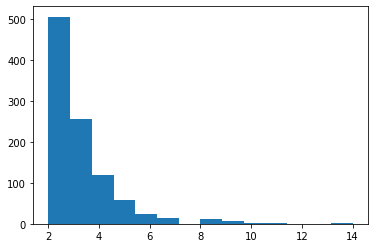

In [145]:
Network = Network()

In [73]:
print(Network.T)

AttributeError: type object 'Network' has no attribute 'T'

In [43]:
np.zeros((1,1))[:1, :1]

array([[0.]])

In [44]:
def test_for_else():
    for i in range(10):
        if i == 5:
            return
    else:
        print("Hij komt ook bij else clause bij een return")
        
test_for_else()